## Dependencias

In [427]:
import numpy as np
import pandas as pd
import re
import os

from collections import Counter
from functools import reduce

import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import cufflinks as cf
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS,TSNE
from sklearn.pipeline import make_pipeline

from varclushi import VarClusHi

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)
cf.go_offline()

## Carga de datos

In [386]:
with open('data/_chat.txt','r') as f:
    texto = f.read()
    f.close()

In [387]:
fechas = [l.split(']')[0] for l in texto.split('[')]
fechas = [f if len(f)==17 else f[:9]+'0'+f[9:] for f in fechas]
contactos = ["".join(l.split(']')[1:]).split(':')[0] for l in texto.split('[')]
mensajes = ["".join("".join(l.split(']')[1:]).split(':')[1:]).replace('\n',' ').strip() for l in texto.split('[')]

In [388]:
len(mensajes),len(fechas),len(contactos)

(709, 709, 709)

In [389]:
df = pd.DataFrame(dict(zip(['fecha','contacto','mensaje'],(fechas,contactos,mensajes))))

In [390]:
df = df.loc[df['mensaje']!=''].reset_index(drop=True)
df = df.loc[df['contacto']!=' ⚽ Peñarol'].reset_index(drop=True)
df = df.loc[df['contacto']!=' Jesus Eugenio'].reset_index(drop=True)
completo = df[['mensaje']]

In [391]:
df['fecha'] = pd.to_datetime(df['fecha'])

## Preprocesamiento

### Minúsculas

In [392]:
df['mensaje'] = df['mensaje'].map(str.lower).map(lambda x:x.replace('\n',' '))

### Stopwords

In [393]:
STOP_WORDS = STOP_WORDS.union(set(stopwords.words('spanish')))

df['mensaje'] = df['mensaje'].map(lambda x: [w for w in x.split(' ') if w not in STOP_WORDS]).apply(" ".join)
df.head()

,fecha,contacto,mensaje
0,2021-04-28 18:11:47,José Gustavo,tardes horario juego sabado 1 mayo 1900 hrs
1,2021-04-28 18:11:54,José Gustavo,tardes
2,2021-04-28 18:12:01,José Gustavo,juego sábado 19
3,2021-04-28 18:12:05,José Gustavo,confirmen favor
4,2021-04-28 18:12:18,José Gustavo,playera verde


### Lematización

In [394]:
spacy.cli.download("es_core_news_md")
nlp = spacy.load('es_core_news_md')

df['mensaje'] = df['mensaje'].map(nlp).map(lambda x:[w.lemma_ for w in x]).apply(" ".join)
df.head()

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


,fecha,contacto,mensaje
0,2021-04-28 18:11:47,José Gustavo,tarde horario jugar sabado 1 mayar 1900 hrs
1,2021-04-28 18:11:54,José Gustavo,tarde
2,2021-04-28 18:12:01,José Gustavo,jugar sábado 19
3,2021-04-28 18:12:05,José Gustavo,confirmar favor
4,2021-04-28 18:12:18,José Gustavo,playero verde


### Puntuación

In [395]:
df['mensaje'] = df['mensaje'].map(lambda x:re.sub(r'[\uD83C-\uDBFF\uDC00-\uDFFF]+','',x, re.UNICODE))

### Hapaxes

In [396]:
conteos = Counter(reduce(lambda x,y:x+y,df['mensaje'].map(lambda x:x.split(' '))))

hapaxes = [t for t,count in conteos.items() if count == 1 or t == '']
df['mensaje'] = df['mensaje'].map(lambda x:[w for w in x.split(' ') if w not in hapaxes]).apply(" ".join)
df.head()

,fecha,contacto,mensaje
0,2021-04-28 18:11:47,José Gustavo,tarde horario jugar sabado 1
1,2021-04-28 18:11:54,José Gustavo,tarde
2,2021-04-28 18:12:01,José Gustavo,jugar sábado
3,2021-04-28 18:12:05,José Gustavo,confirmar favor
4,2021-04-28 18:12:18,José Gustavo,verde


### Stopwords v2

In [397]:
STOP_WORDS = STOP_WORDS.union({'confirmar','equipar'})
df['mensaje'] = df['mensaje'].map(lambda x: [w for w in x.split(' ') if w not in STOP_WORDS]).apply(" ".join)
df.head()

,fecha,contacto,mensaje
0,2021-04-28 18:11:47,José Gustavo,horario jugar sabado 1
1,2021-04-28 18:11:54,José Gustavo,
2,2021-04-28 18:12:01,José Gustavo,jugar sábado
3,2021-04-28 18:12:05,José Gustavo,favor
4,2021-04-28 18:12:18,José Gustavo,verde


## Análisis Exploratorio

### WordClouds

In [398]:
aux = df[['contacto','mensaje']].groupby('contacto').agg(" ".join)

 Cdd_rolando_oviedo


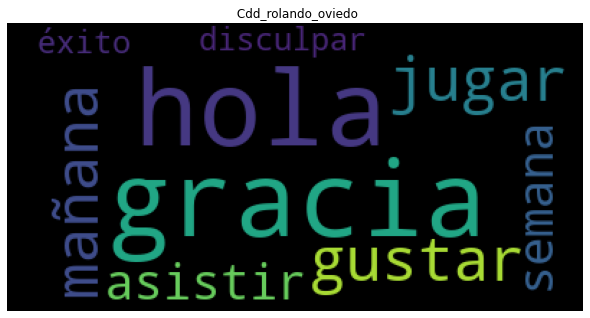

 David Rayon


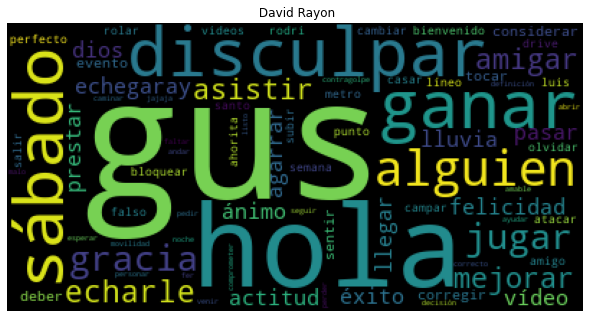

 Fernando Narvaez


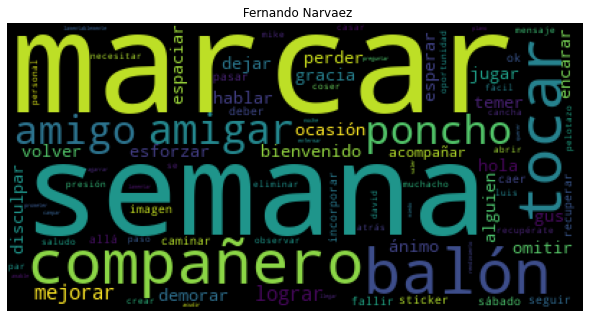

 Fut_sabado_Jorge Enrique Lopez


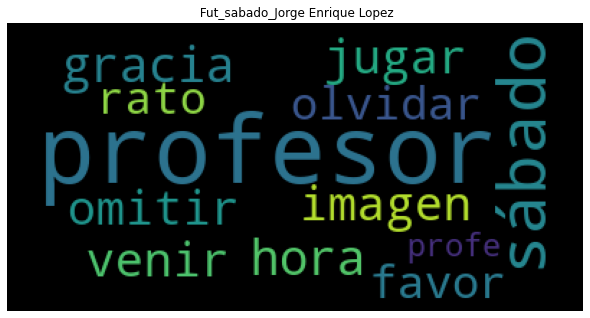

 Fut_sabado_Manuel


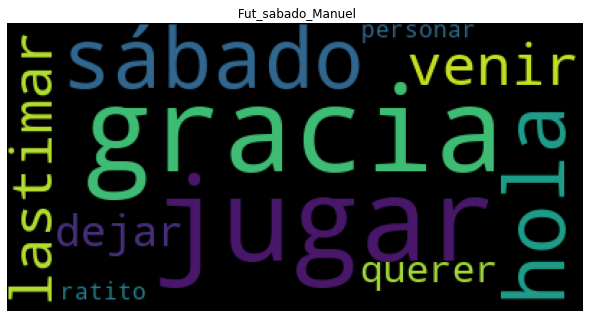

 Fut_sabado_eduardo Maya


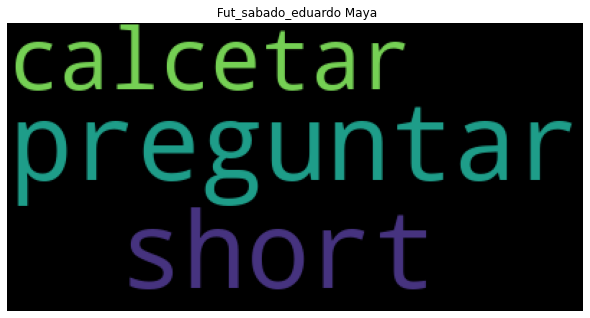

 Fut_sabado_ivan Hernandez


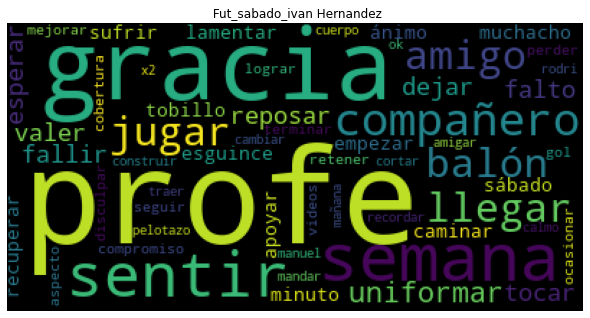

 Fut_sabado_luis Avendaño


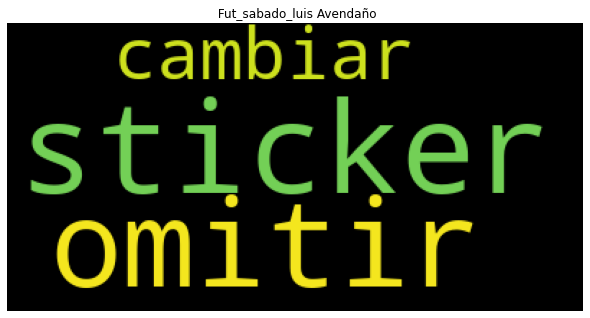

 Fut_sabado_rodrigo Sanchez


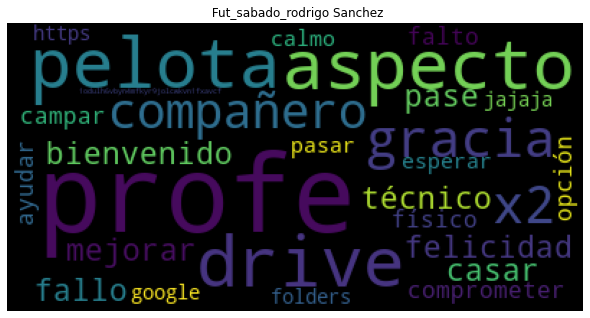

 Gustavo Hernandez Erreguin


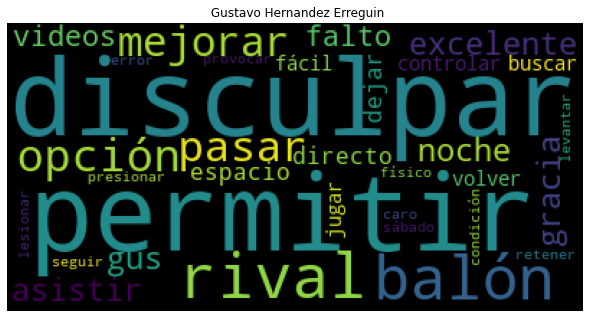

 Joel García I


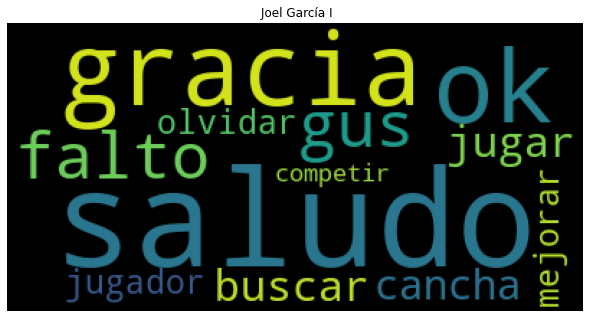

 José Gustavo


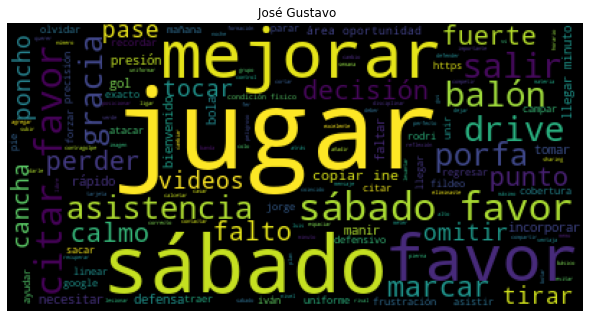

 Luis García Isidro


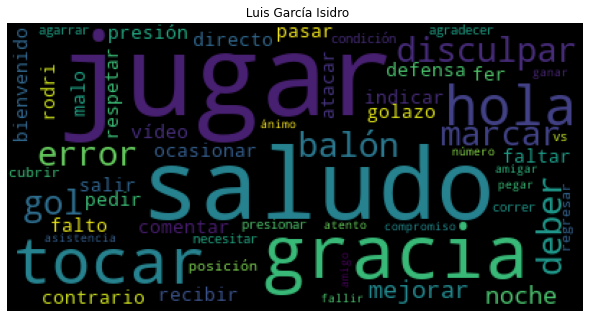

 Marquito


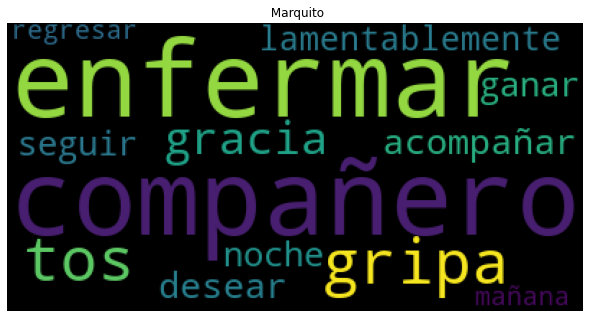

 Memo Anaya


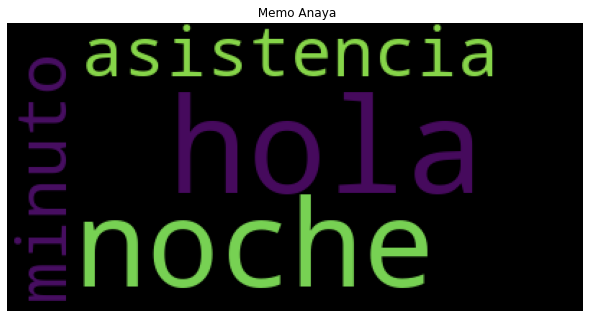

 Miguel Peñaflor


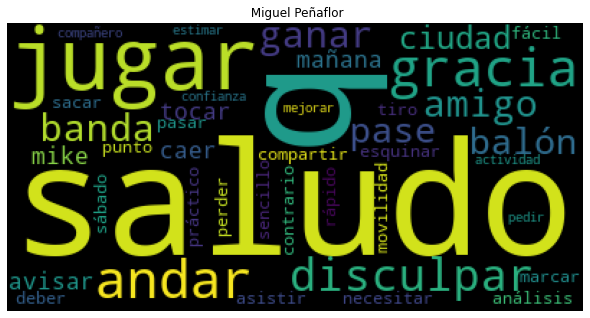

 Raymundo Guevara


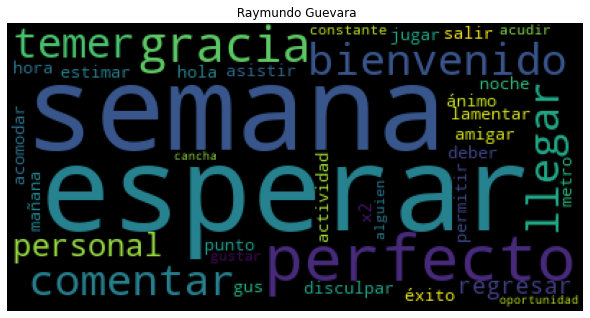

 S7_Poncho


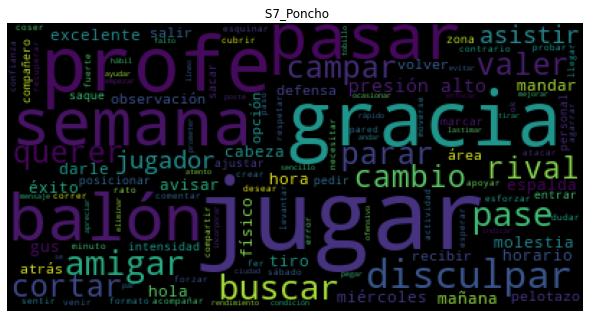

 ‪+52 55 6939 3308‬


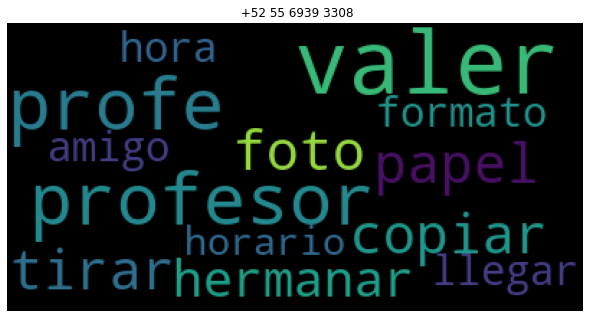

In [399]:
for i,row in aux.iterrows():
    print(i)
    wc = WordCloud()
    wc.generate_from_text(row['mensaje'])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(i)
    plt.tight_layout(pad = 0)
    plt.show()

### Frecuencia de mensajes por contacto

In [400]:
df.drop('fecha',axis=1).groupby(['contacto']).count().sort_values(by='mensaje',ascending=False).iplot(kind='bar')

### Frecuencia de mensajes por fecha

In [401]:
aux = df[['fecha','mensaje']].copy()
aux['fecha'] =aux['fecha'].map(lambda x:x.strftime('%Y%W'))
aux.groupby('fecha').count().iplot(kind='bar')

## Vectorizar texto

In [402]:
len(reduce(lambda x,y:x.union(y),df['mensaje'].map(lambda x:set(x.split(' ')))))

379

In [403]:
tfidf = TfidfVectorizer(encoding='utf8',max_features=50,ngram_range=(1,3))
tfidf.fit(df['mensaje'])
df_tfidf = pd.DataFrame(tfidf.transform(df['mensaje']).todense())
df_tfidf.columns = [f'wt_{w}' for w in tfidf.get_feature_names()]

## Reducción de dimensiones

In [404]:
vc = VarClusHi(df=df_tfidf,feat_list=df_tfidf.filter(like='wt_').columns)
vc.varclus()
rs = vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])
best_tfidf = rs.groupby('Cluster').first()['Variable'].to_list()


In [405]:
best_tfidf

['wt_calmo',
 'wt_condición',
 'wt_favor',
 'wt_minuto',
 'wt_jugar',
 'wt_amigo',
 'wt_dejar',
 'wt_videos',
 'wt_compañero',
 'wt_presión',
 'wt_gracia',
 'wt_campar',
 'wt_mañana',
 'wt_deber',
 'wt_gus',
 'wt_tirar',
 'wt_asistencia',
 'wt_drive']

## Clustering

In [406]:
X = df_tfidf[best_tfidf].copy()

In [407]:
l = []
for k in range(2,20):
    cl = GaussianMixture(n_components=k)
    cl.fit(X)
    l.append((k,silhouette_score(X,cl.predict(X))))
sil = pd.DataFrame(l,columns=['k','sil']).set_index('k')
sil.iplot(mode='lines+markers')

In [408]:
k = 3
cl = GaussianMixture(n_components=k)
cl.fit(X)

GaussianMixture(n_components=3)

In [409]:
df['cl_tfidf'] = cl.predict(X)

In [410]:
aux = df.drop(['contacto','fecha'],axis=1).groupby('cl_tfidf').agg(lambda x:" ".join(x))
aux['mensaje'] = aux['mensaje'].map(lambda x:[w for w in x.split(' ') if w not in ('\n','',' ')]).apply(" ".join)

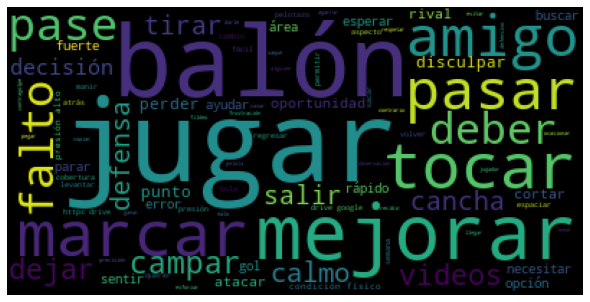

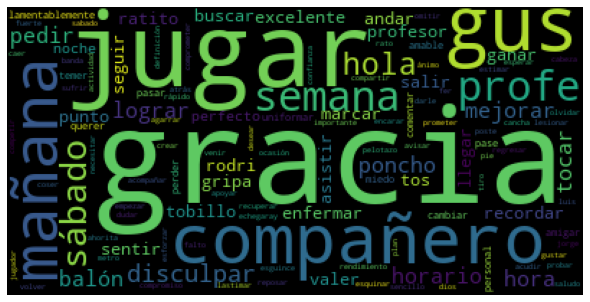

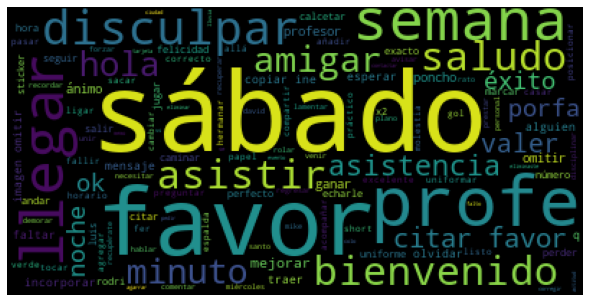

In [411]:
for i,row in aux.iterrows():
    wc = WordCloud()
    wc.generate_from_text(row['mensaje'])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [412]:
aux

mensaje
cl_tfidf                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Top 10 palabras cluster

In [413]:
aux = df[['cl_tfidf','mensaje']].groupby('cl_tfidf').agg(" ".join)
aux['mensaje'] = aux['mensaje'].map(lambda x:[w for w in x.strip().split(' ') if w!=' ']).map(Counter)
aux['mensaje'] = aux['mensaje'].map(lambda x:"|".join(list(pd.Series(x).sort_values(ascending=False).head(10).index)))

In [414]:
aux

,mensaje
cl_tfidf,
0,",|.|jugar|balón|mejorar|tocar|marcar|pasar|amigo|pase"
1,",|gracia|jugar|.|!|gus|compañero|mañana|semana|profe"
2,"|,|.|!|?|👍|sábado|favor|profe|llegar"


In [415]:
df['completo'] = completo['mensaje']

In [416]:
df.loc[df['cl_tfidf']==7]

,fecha,contacto,mensaje,cl_tfidf,completo


## Visualizar el cluster en el espacio

In [417]:
X['cl'] = df['cl_tfidf'].map(lambda x:'cl%02d'%x)

In [419]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X[best_tfidf]),columns=best_tfidf)
mds = MDS(n_components=2,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(Xs),columns=['d1','d2'])
Xm['cl'] = X['cl']

Xm.iplot(kind='scatter',
                               x='d1',
                               y='d2',
                               mode='markers',
                               categories='cl')

In [422]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X[best_tfidf]),columns=best_tfidf)
mds = MDS(n_components=3,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(Xs),columns=['d1','d2','d3'])
Xm['cl'] = X['cl']

In [424]:
Xm.iplot(kind='scatter3d',
                               x='d1',
                               y='d2',
                               z='d3',
                               mode='markers',
                               categories='cl')

In [428]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(X[best_tfidf]),columns=best_tfidf)
tsne = TSNE(n_components=2,n_jobs=-1)
Xm = pd.DataFrame(tsne.fit_transform(Xs),columns=['d1','d2'])
Xm['cl'] = X['cl']

Xm.iplot(kind='scatter',
                               x='d1',
                               y='d2',
                               mode='markers',
                               categories='cl')

/home/jose/entornos/ins/lib/python3.8/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

/home/jose/entornos/ins/lib/python3.8/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

